In [1]:
pip install cartopy

  Using cached numpy-2.3.1-cp312-cp312-win_amd64.whl.metadata (60 kB)
  Using cached matplotlib-3.10.3-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached contourpy-1.3.2-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.58.4-cp312-cp312-win_amd64.whl.metadata (108 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   - -------------------------------------- 0.5/11.0 MB 3.4 MB/s eta 0:00:04
   -- ------------------------------------- 0.8/11.0 MB 2.8 MB/s eta 0:00:04
   ---- ----------------------------------- 1.3/11.0 MB 2.2 MB/s eta 0:00:05
   ------ --------------------------------- 1.8/11.0 MB 2.4 MB/s eta 0:00:04
   --------- ------------------------------ 2.


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


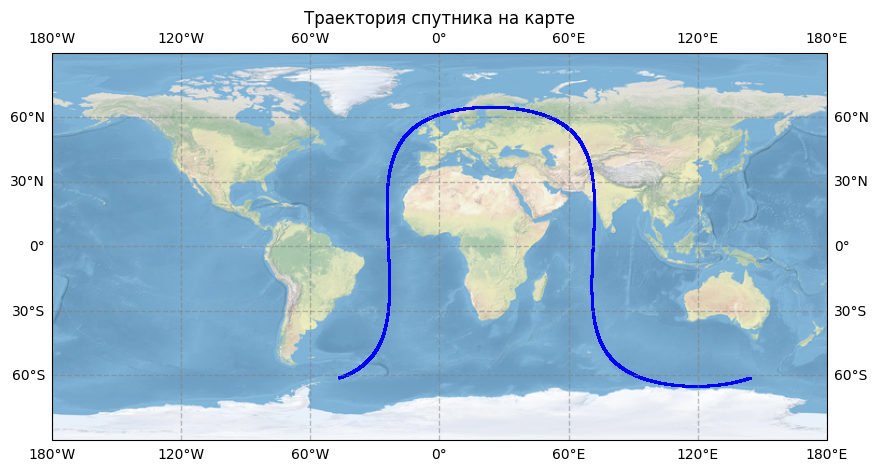

In [2]:
import numpy as np
from pyproj import Proj, Transformer
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

# Заданные постоянные
mu = 3.986e5  # Гравитационный параметр Земли
Rz = 6371  # Средний радиус Земли, км
ha = 19174  # Апогейная высота, км
hp = 19100  # Перигейная высота, км
e = 0.00145  # Эксцентриситет орбиты
T = 40544  # Период обращения, секунды
tp = T - 1689.33  # Время прохождения перигея
t = np.linspace(0, T, num=T+1)  # Временной ряд от 0 до T включительно
a = 25508.039  # Большая полуось орбиты, км
wz = 7.2921158e-5  # Скорость вращения Земли, рад/с
wp = 3 * np.pi / 2  # Аргумент перигея
W = 0.1963  # Долгота восходящего узла
inclination = 1.130973  # Наклонение орбиты

# Эксцентрическая аномалия
E1 = np.sqrt(mu / a**3) * (t - tp)
E2 = np.zeros_like(E1)

# Решатель уравнения Кеплера
for i in range(len(E1)):
    E2[i] = E1[i]
    while True:
        prev_E2 = E2[i]
        E2[i] = e * np.sin(prev_E2) + np.sqrt(mu / a**3) * (t[i] - tp)
        if abs(E2[i] - prev_E2) < 1e-15:
            break

# Уточнение эксцентрической аномалии
E1 = E2.copy()
E1[E1 > np.pi] -= 2 * np.pi

# Истинная аномалия
deltas = np.where(E1 > np.pi, 2 * np.pi, 0)
true_anomaly = deltas + 2 * np.arctan(np.sqrt((1 + e) / (1 - e)) * np.tan(E1 / 2))

# Радиус-вектор
r = a * (1 - e**2) / (1 + e * np.cos(true_anomaly))

# Прямоугольные координаты
x = r * (
    (np.cos(wp) * np.cos(W) - np.sin(W) * np.sin(wp) * np.cos(inclination)) *
    np.cos(true_anomaly) -
    (np.cos(W) * np.sin(wp) + np.cos(wp) * np.sin(W) * np.cos(inclination)) *
    np.sin(true_anomaly)
)

y = r * (
    (np.cos(wp) * np.sin(W) + np.cos(W) * np.sin(wp) * np.cos(inclination)) *
    np.cos(true_anomaly) +
    (-np.sin(W) * np.sin(wp) + np.cos(wp) * np.cos(W) * np.cos(inclination)) *
    np.sin(true_anomaly)
)

z = r * (np.sin(wp) * np.cos(true_anomaly) + np.cos(wp) * np.sin(true_anomaly)) * np.sin(inclination)

# Гринвичская вращающаяся система координат
xg = x * np.cos(wz * t) + y * np.sin(wz * t)
yg = -x * np.sin(wz * t) + y * np.cos(wz * t)
zg = z.copy()

# Преобразование из геоцентрических (ECEF) в геодезические координаты
ecef_proj = Proj(proj='geocent', ellps='WGS84', units='m')  # Геоцентрическая система координат
lla_proj = Proj(proj='latlong', ellips='WGS84', datum='WGS84')  # Геодезическая система координат

# Новый трансформер для замены старого метода transform
transformer = Transformer.from_proj(ecef_proj, lla_proj)

# Масштабируем координаты на километры в метры
x_meters = xg * 1000
y_meters = yg * 1000
z_meters = zg * 1000

# Трансформируем координаты
lon, lat, alt = transformer.transform(x_meters, y_meters, z_meters)

# Строим график траектории НА КАРТЕ
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Загружаем слой карты Natural Earth с разрешением 110 метров
ax.stock_img()

# Наносим сетку координат
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Нарисуем траекторию спутника
ax.scatter(lon[1:], lat[1:], s=1, marker='o', color='blue', transform=ccrs.PlateCarree())

# Название графика
plt.title('Траектория спутника на карте')

# Покажем график
plt.show()
